## Package Import

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00


In [ ]:
from darts.models import Prophet, LinearRegressionModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mase, r2_score
from darts import concatenate
from darts.dataprocessing.transformers import MinTReconciliator, BottomUpReconciliator, TopDownReconciliator
import pandas as pd
from pandas import Timestamp


# Model

### Data Import + Utils

In [ ]:

# Load the data from an Excel file
file_path = 'SampleHierForecastingBASF_share.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')

# Ensure the dataframe is sorted by date
df = df.sort_values(by='Date')

# Split the data into Train, Test, and Validation datasets
train_data = df[(df['Date'] >= '2008-01-01') & (df['Date'] <= '2021-12-31')]
test_data = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]
validation_data = df[(df['Date'] >= '2023-01-01') & (df['Date'] <= '2023-12-31')]

# Display the sizes of the splits
print(f"Training Data Size: {train_data.shape[0]} rows")
print(f"Testing Data Size: {test_data.shape[0]} rows")
print(f"Validation Data Size: {validation_data.shape[0]} rows")

# Verify the splits (optional)
print("Training Data Sample:")
print(train_data.head())

Training Data Size: 168 rows
Testing Data Size: 12 rows
Validation Data Size: 12 rows
Training Data Sample:
        Date      NetSales  VariableCosts  ContributionMargin1      FixCosts  \
0 2008-01-01  46395.562988   11530.938420         34864.624569  28085.056839   
1 2008-02-01  71258.917420   23005.990813         48252.926607  25574.419442   
2 2008-03-01  82672.156481   33251.338936         49420.817545  23989.711891   
3 2008-04-01  91239.441986   33569.084866         57670.357120  26096.657423   
4 2008-05-01  76852.388916   31133.385550         45719.003366  23010.859671   

           EBIT  DepreciationAmortization        EBITDA  
0   6779.567730               3913.291983  10692.859713  
1  22678.507166               2656.703148  25335.210314  
2  25431.105654               3308.918478  28740.024133  
3  31573.699697               4013.632803  35587.332501  
4  22708.143695               3241.601219  25949.744914  


In [ ]:
def get_metrics(pred,val, name ):
  print(f"MAE for {name}: {mae(val,pred):.2f}")
  #print(f"MASE for {name}: {mase(val,pred):.2f}")
  print(f"MAPE for {name}: {mape(val,pred):.2f}")
  print(f"RMSE for {name}: {rmse(val, pred):.2f}")
  print(f"R-squared for {name}: {r2_score(val, pred):.2f}")

### Prediction

#### Implementing Hierarchy

In [ ]:
df['-VariableCosts'] = -df['VariableCosts']
df['-DepreciationAmortization']=-df['DepreciationAmortization']
df['-FixCosts'] = -df['FixCosts']

In [ ]:
topdown = ["EBITDA", "-DepreciationAmortization"]
bottomup2 = ["ContributionMargin1", "-FixCosts"]
bottomup1 = ["NetSales", "-VariableCosts"]

In [ ]:
hierarchy = dict()

# Fill in topdown variables
for var in topdown:
    hierarchy[var] = ["EBIT"]

# Fill in bottomup2 variables
for var in bottomup2:
    hierarchy[var] = ["EBIT"]

# Fill in bottomup1 variables
for var in bottomup1:
    hierarchy[var] = ["ContributionMargin1"]

In [ ]:
hierarchy = {
    'EBITDA': ['EBIT'],
    '-DepreciationAmortization': ['EBIT'],
    'ContributionMargin1': ['EBIT'],
    '-FixCosts': ['EBIT'],
    'NetSales': ['ContributionMargin1'],
    '-VariableCosts': ['ContributionMargin1']
}

series = TimeSeries.from_dataframe(df, time_col="Date", value_cols=[
    "EBIT","EBITDA", "-DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"
])
series = series.with_hierarchy(hierarchy)

#### Adding Covariates

In [ ]:
#yearly global inflation data from world bank, extra explanatory variable for model
inflation = pd.read_excel('globalinflation.xlsx')
inflation = inflation.T
inflation.index = pd.to_datetime(inflation.index, format='%Y')
# Create a complete date range from the first month of the first year to the last month of the last year
start_date = inflation.index.min()
end_date = inflation.index.max() + pd.DateOffset(months=11)  # Go to the last month of the final year

# Generate a date range for all months in the period
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

# Reindex the DataFrame to this new monthly range (this adds missing months)
inflation = inflation.reindex(date_range)
#inflation = inflation.ffill()
inflation = inflation.interpolate(method="linear")
inflation = inflation.reset_index()
inflation.columns = ["date","inflation_rate"]
#now inf_series is the estimated global monthly inflation rates
inf_series = TimeSeries.from_dataframe(inflation, time_col="date", value_cols="inflation_rate")

(192, 2)

In [ ]:
# future_cov are additional explanatory features extrapolated from datetime, recommended for profit
future_cov = datetime_attribute_timeseries(series, "month", cyclic=True)
future_cov = future_cov.stack(datetime_attribute_timeseries(series, "year", cyclic=False))
future_cov = future_cov.stack(datetime_attribute_timeseries(series, "quarter", cyclic=True))
#TODO: try adding 1,3, 6 month lags
#future_cov = future_cov.stack(lagged)
future_cov = future_cov.stack(inf_series)

#### Model Training (2022 as validation year)

In [ ]:
train, val = series[:-24], series[-24:-12]
#with covariates
model = LinearRegressionModel(lags=12, lags_future_covariates=[12,12,12,12])
model.fit(train, future_covariates=future_cov)
pred = model.predict(n=len(val), future_covariates=future_cov)

In [ ]:
#without covariates, don't run both this cell and the previous!!!
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

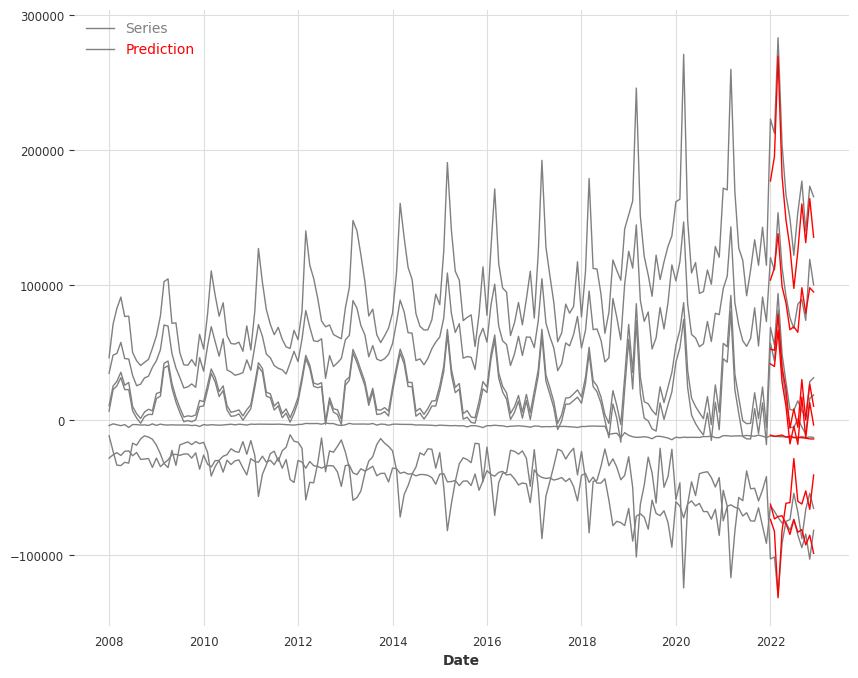

In [ ]:
#how did we do? plot to see
components_to_show = ["EBIT","EBITDA", "-DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]
plt.figure(figsize=(10, 8))
#filter so we only show dates we actually calculated predictions for
filtered_series = series.drop_after(Timestamp('2022-12-31'))
filtered_series[components_to_show].plot(lw=1, color='gray', label='Series')
pred[components_to_show].plot(lw=1, color='red', label='Prediction')

plt.legend(["Series", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.show()

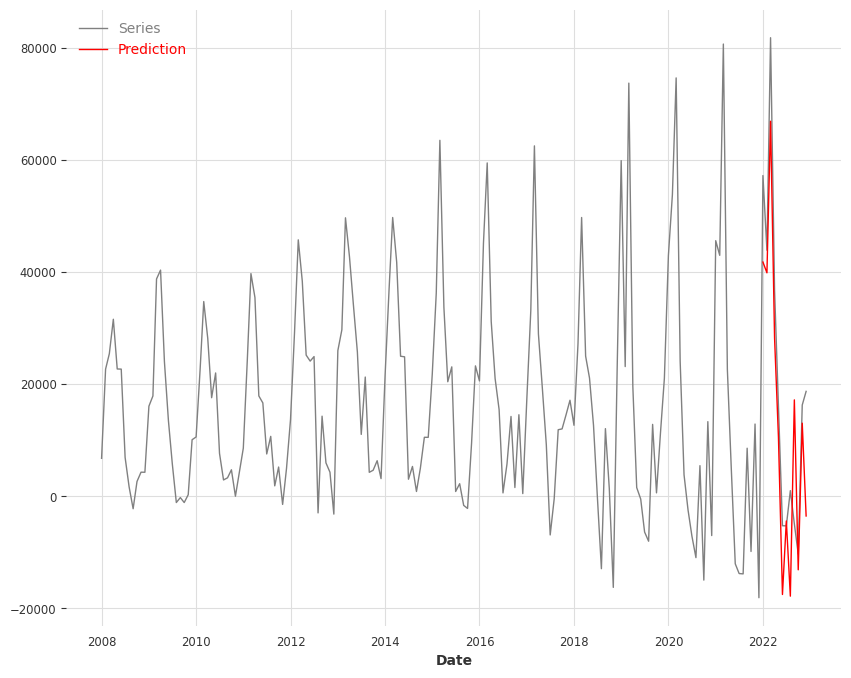

In [ ]:

# a lot going on there, let's just look at the target variable
plt.figure(figsize=(10, 8))
filtered_series['EBIT'].plot(lw=1, color='gray', label='Series')
pred['EBIT'].plot(lw=1, color='red', label='Prediction')

plt.legend(["Series", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.show()

### Reconciliation

In [ ]:
# Define hierarchical levels
level_1 = ["EBIT"]  # Top-level
level_2 = ["ContributionMargin1", "-FixCosts"]
level_3 = ["EBITDA", "-DepreciationAmortization"]
level_4 = ["NetSales", "-VariableCosts","-FixCosts"]

# Measure  at each hierarchical level
get_metrics(pred[level_1], series[level_1], "Level 1 (Top-Level: EBIT)")
get_metrics(pred[level_2], series[level_2], "Level 2 Components)")
get_metrics(pred[level_3], series[level_3], "Level 3 Components)")
get_metrics(pred[level_4], series[level_4], "Level 4 Components)")




MAPE for Level 1 (Top-Level: EBIT): 207.04
R-squared for Level 1 (Top-Level: EBIT): 0.80
MAPE for Level 2 Components): 16.47
R-squared for Level 2 Components): -0.65
MAPE for Level 3 Components): 51.26
R-squared for Level 3 Components): -8.97
MAPE for Level 4 Components): 19.01
R-squared for Level 4 Components): -0.36


In [ ]:
reconciliator0 = MinTReconciliator(method="wls_val")
reconciliator0.fit(train)
reconciled0_preds = reconciliator0.transform(pred)
get_metrics(reconciled0_preds, val, "MinT")
#plot_forecast_sums(reconciled0_preds)

MAE for MinT: 37415.45
MAPE for MinT: 114.37
RMSE for MinT: 47904.00
R-squared for MinT: -52.54


In [ ]:
reconciliator1 = BottomUpReconciliator()
reconciled1_preds = reconciliator1.transform(pred)
get_metrics(reconciled1_preds, val, "Bottom Up")
#plot_forecast_sums(reconciled1_preds)

MAE for Bottom Up: 13036.60
MAPE for Bottom Up: 86.66
RMSE for Bottom Up: 15169.75
R-squared for Bottom Up: 0.10


In [ ]:
#this performs worst, which makes theoretical sense based on our hierarchy
reconciliator2 = TopDownReconciliator()
reconciliator2.fit(train)
reconciled2_preds = reconciliator2.transform(pred)
get_metrics(reconciled2_preds, val, "Top Down")
#plot_forecast_sums(reconciled2_preds)

MAE for Top Down: 56916.56
MAPE for Top Down: 142.81
RMSE for Top Down: 65554.21
R-squared for Top Down: -90.00


### Backtesting

In [ ]:
#backtesting

backtest_results = model.historical_forecasts(
    series["EBIT"],
    future_covariates=future_cov,
    start=0.6,  # Start backtesting after 60% of the dataset
    forecast_horizon=6,
    stride=1,  # Move forward one step at a time
    retrain=True,  # Retrain after each forecast
)



In [ ]:

models = [ExponentialSmoothing(), Prophet()]
backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=3) for model in models]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

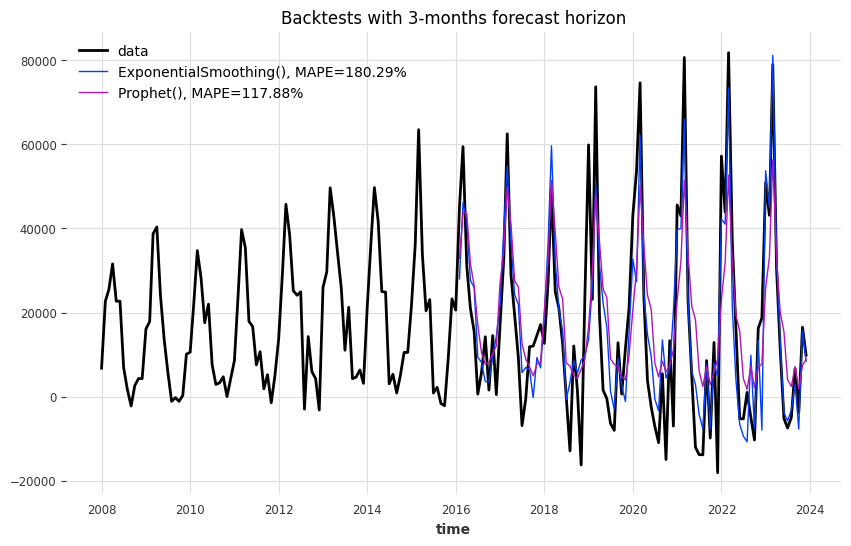

In [ ]:
from darts.metrics import mape

plt.figure(figsize=(10, 6))

series['EBIT'].plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series['EBIT'])
    backtests[i].plot(lw=1, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()